To run the following code in Google Colab you need these libraries. More details in requirements.txt.

In [ ]:
!pip install datasets transformers torch seqeval

In [ ]:
!pip install accelerate -U

# Data preparation

In [ ]:
# Load the dataset.

from datasets import load_dataset

dataset = load_dataset("Babelscape/multinerd")

In [ ]:
# Check the structure of the dataset.

dataset

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags', 'lang'],
        num_rows: 2678400
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'lang'],
        num_rows: 334800
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'lang'],
        num_rows: 335986
    })
})

In [4]:
# Filter out non-English data.

en_dataset = dataset.filter(lambda example: example['lang'] == 'en')

Filter:   0%|          | 0/2678400 [00:00<?, ? examples/s]

Filter:   0%|          | 0/334800 [00:00<?, ? examples/s]

Filter:   0%|          | 0/335986 [00:00<?, ? examples/s]

In [ ]:
# Check the number of examples in the train, validation, and test sets of the English sub-dataset.

print('Number of examples in train, validation, and test sets:',
      len(en_dataset["train"]), len(en_dataset["validation"]), len(en_dataset["test"]))

Number of examples in train, validation, and test sets: 262560 32820 32908


In [ ]:
# Check the content of an example

en_dataset["train"][0]

{'tokens': ['The', 'type', 'locality', 'is', 'Kīlauea', '.'],
 'ner_tags': [0, 0, 0, 0, 5, 0],
 'lang': 'en'}

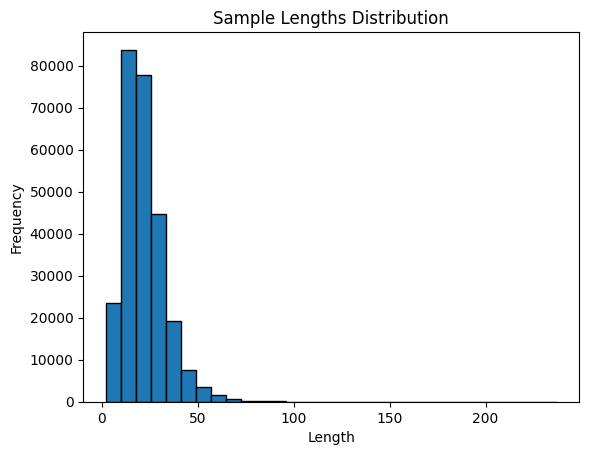

In [ ]:
# Plot out the number of tokens in each example in the training set

import matplotlib.pyplot as plt
import numpy as np

sample_lengths = [len(sample["tokens"]) for sample in en_dataset["train"]]

plt.hist(sample_lengths, bins=30, edgecolor='black')
plt.title("Sample Lengths Distribution")
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.show()

In [ ]:
# Check the maximum length

max_length = np.max(sample_lengths)
max_length

237

In [5]:
# Copy the label2id dictionary from https://huggingface.co/datasets/Babelscape/multinerd?row=0
label2id = {
    "O": 0,
    "B-PER": 1,
    "I-PER": 2,
    "B-ORG": 3,
    "I-ORG": 4,
    "B-LOC": 5,
    "I-LOC": 6,
    "B-ANIM": 7,
    "I-ANIM": 8,
    "B-BIO": 9,
    "I-BIO": 10,
    "B-CEL": 11,
    "I-CEL": 12,
    "B-DIS": 13,
    "I-DIS": 14,
    "B-EVE": 15,
    "I-EVE": 16,
    "B-FOOD": 17,
    "I-FOOD": 18,
    "B-INST": 19,
    "I-INST": 20,
    "B-MEDIA": 21,
    "I-MEDIA": 22,
    "B-MYTH": 23,
    "I-MYTH": 24,
    "B-PLANT": 25,
    "I-PLANT": 26,
    "B-TIME": 27,
    "I-TIME": 28,
    "B-VEHI": 29,
    "I-VEHI": 30,
  }

# Create an id2label dictionary
id2label = {id: label for label, id in label2id.items()}

For system B, all
examples should only remain 5 entity types: PERSON(PER), ORGANIZATION(ORG), LOCATION(LOC), DISEASES(DIS), and ANIMAL(ANIM). Entity types not belonging to one of the following five are set to zero.

In [6]:
# New id2label
new_id2label = {0: 'O', 1: 'B-PER', 2: 'I-PER',
                3: 'B-ORG', 4: 'I-ORG',
                5: 'B-LOC', 6: 'I-LOC',
                7: 'B-DIS', 8: 'I-DIS',
                9: 'B-ANIM', 10: 'I-ANIM'}

# New label2id
new_label2id = {label: idx for idx, label in new_id2label.items()}

# Change the ner tags according to the new label ids.
def convert_labels(example):
    converted_labels = [new_label2id.get(id2label[label_id], 0) for label_id in example['ner_tags']]
    example['ner_tags'] = converted_labels
    return example

converted_en_dataset = en_dataset.map(convert_labels)

Map:   0%|          | 0/262560 [00:00<?, ? examples/s]

Map:   0%|          | 0/32820 [00:00<?, ? examples/s]

Map:   0%|          | 0/32908 [00:00<?, ? examples/s]

In [ ]:
"""
Compare an example's ner tags before and after convertion:
The tag "9" should be converted to "0",
since this entity type is turned into "O".
"""
print(en_dataset["train"][10]['ner_tags'])
print(converted_en_dataset["train"][10]['ner_tags'])

[0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [10]:
# Check the proportions of different labels in the train set now.

from collections import Counter

# Flat the labels into one list
all_labels = [label for example in converted_en_dataset['train'] for label in example['ner_tags']]

# Count the labels in this list
label_counts = Counter(all_labels)

# Group the labels by entitiy type (Entity A - E and O)
label_groups = {
    'A': [1, 2],
    'B': [3, 4],
    'C': [5, 6],
    'D': [7, 8],
    'E': [9, 10],
    '0': [0]
}

# Count the labels per group and get the proportions of each group
grouped_label_counts = {group: sum(label_counts[label] for label in labels) for group, labels in label_groups.items()}
grouped_total_labels = sum(grouped_label_counts.values())
grouped_label_proportions = {group: count / grouped_total_labels for group, count in grouped_label_counts.items()}

# Print the proportions of each group
for group, count in grouped_label_counts.items():
    proportion = grouped_label_proportions[group]
    print(f"Label Group: {group}, Count: {count}, Proportion: {proportion:.2%}")

Label Group: A, Count: 258350, Proportion: 4.55%
Label Group: B, Count: 127280, Proportion: 2.24%
Label Group: C, Count: 166130, Proportion: 2.92%
Label Group: D, Count: 29012, Proportion: 0.51%
Label Group: E, Count: 36086, Proportion: 0.63%
Label Group: 0, Count: 5067380, Proportion: 89.15%


In [ ]:
# Align the labels in tokenized_inputs with the labels of words in dataset.
# Here DistilBertTokenizerFast is used as the tokenizer,
# initialized with huggingface's 'distilbert-base-cased' model's tokenizer config.

from transformers import DistilBertTokenizerFast

tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-cased')

def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)

    labels = []
    for i, label in enumerate(examples[f"ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)  # Special token
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            else:
                label_ids.append(-100)  # Duplicate token
            previous_word_idx = word_idx
        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

# Create a tokenized dataset with the above function.
tokenized_en_dataset = converted_en_dataset.map(tokenize_and_align_labels, batched=True)
tokenized_en_dataset

Map:   0%|          | 0/32820 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags', 'lang', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 262560
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'lang', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 32820
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'lang', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 32908
    })
})

In [ ]:
# Retain the necessary columns for training the model.

tokenized_en_dataset = tokenized_en_dataset.remove_columns(["tokens", "ner_tags", "lang"])
tokenized_en_dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 262560
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 32820
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 32908
    })
})

# Model training

In [ ]:
# Define the evaluation metric: seqeval F1

from seqeval.metrics import f1_score

def metrics_func(eval_arg):
  preds = np.argmax(eval_arg.predictions, axis=2)
  batch_size, seq_len = preds.shape
  y_true, y_pred = [], []
  for b in range(batch_size):
    true_label, pred_label = [], []
    for s in range(seq_len):
      if eval_arg.label_ids[b, s] != -100:  # -100 must be ignored
        true_label.append(id2label[eval_arg.label_ids[b][s]])
        pred_label.append(id2label[preds[b][s]])
    y_true.append(true_label)
    y_pred.append(pred_label)
  return {"f1": f1_score(y_true, y_pred)}

In [ ]:
# Initialize the model "distilbert-base-cased" with seed=42.

from transformers import DistilBertForTokenClassification
import random
import torch
import numpy as np

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
np.random.seed(seed)
random.seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = DistilBertForTokenClassification.from_pretrained('distilbert-base-cased', num_labels=31, id2label=id2label, label2id=label2id).to(device)

model.safetensors:   0%|          | 0.00/263M [00:00<?, ?B/s]

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Define the training arguments for the trainer.

from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=100,
    per_device_eval_batch_size=100,
    num_train_epochs=3,
    fp16 = True,
    evaluation_strategy = "epoch",
    save_strategy="epoch"
)

In [ ]:
# Set up a data collator to pad the tokenized input into the same length

from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(
  tokenizer,
  return_tensors="pt")

In [ ]:
# Set up the trainer

from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_en_dataset["train"],
    eval_dataset=tokenized_en_dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics = metrics_func,
    data_collator = data_collator
)

In [ ]:
# Train the model

trainer.train()

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,F1
1,0.014700,0.021554,0.948468
2,0.006400,0.026376,0.949023
3,0.002400,0.031439,0.950788


TrainOutput(global_step=7878, training_loss=0.015067409102642527, metrics={'train_runtime': 1742.1264, 'train_samples_per_second': 452.137, 'train_steps_per_second': 4.522, 'total_flos': 1.656045678604056e+16, 'train_loss': 0.015067409102642527, 'epoch': 3.0})

# Model testing
Test the model on the test set

In [ ]:
test_result = trainer.predict(test_dataset=tokenized_en_dataset["test"])[-1]['test_f1']
test_result

0.9636505595558255

If someone one to test the model from other checkpoints:

In [ ]:
# Load model from a certain checkpoint
model = (DistilBertForTokenClassification.from_pretrained(
    "./results/checkpoint-15756", num_labels=31, id2label=id2label, label2id=label2id
).to(device))

# Reset the trainer
trainer = Trainer(
  model = model,
  args = training_args,
  data_collator = data_collator,
  compute_metrics = metrics_func,
  train_dataset = tokenized_en_dataset["train"],
  eval_dataset = tokenized_en_dataset["test"],
  tokenizer = tokenizer
)

# Evaluate on the test set
trainer.evaluate()